In [4]:
import torch
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,5)

#### Crossentropy Term 

Text(0.5, 1.0, 'CE-term for predictions and target $p_t=1$')

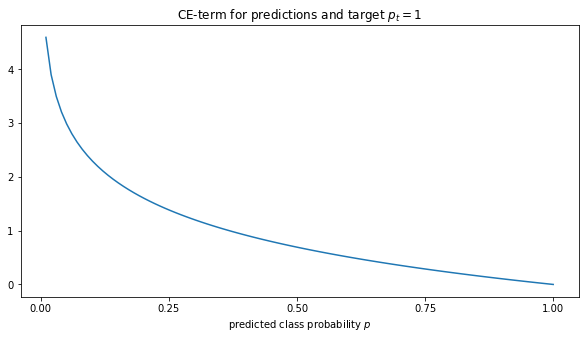

In [34]:
pred = torch.linspace(0, 1, 100)
ce = -torch.log(pred)

plt.plot(pred, ce)
plt.xticks(torch.linspace(0, 1, 5))
plt.xlabel('predicted class probability $p$')
plt.title('CE-term for predictions and target $p_t=1$')

Text(0.5, 1.0, 'CE-term for predictions and targets $p_t$')

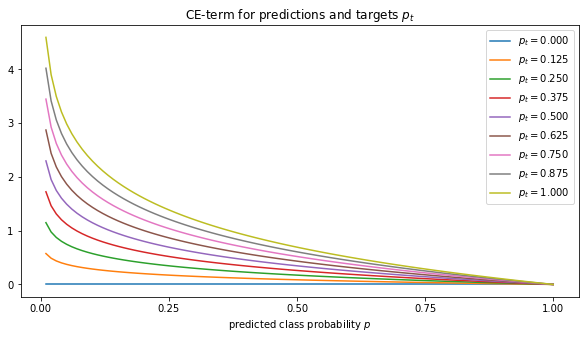

In [35]:
pred = torch.linspace(0, 1, 100).unsqueeze(1)
target = torch.linspace(0, 1, 9).unsqueeze(0)
ce = -target*torch.log(pred)

plt.plot(pred, ce, label=[f'$p_t={t.item():.3f}$' for t in target.T])
plt.xticks(torch.linspace(0, 1, 5))
plt.legend()
plt.xlabel('predicted class probability $p$')
plt.title('CE-term for predictions and targets $p_t$')

#### Crossentropy Loss 

Text(0.5, 1.0, 'CE loss for predictions and targets $p_t$')

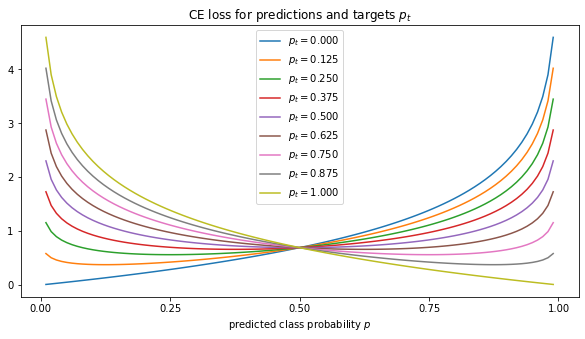

In [36]:
pred = torch.linspace(0, 1, 100).unsqueeze(1)
target = torch.linspace(0, 1, 9).unsqueeze(0)
ce = -(1-target)*torch.log(1-pred) -target*torch.log(pred)

plt.plot(pred, ce, label=[f'$p_t={t.item():.3f}$' for t in target.T])
plt.xticks(torch.linspace(0, 1, 5))
plt.legend()
plt.xlabel('predicted class probability $p$')
plt.title('CE loss for predictions and targets $p_t$')

Text(0.5, 1.0, 'Balanced CE loss for predictions and targets $p_t$')

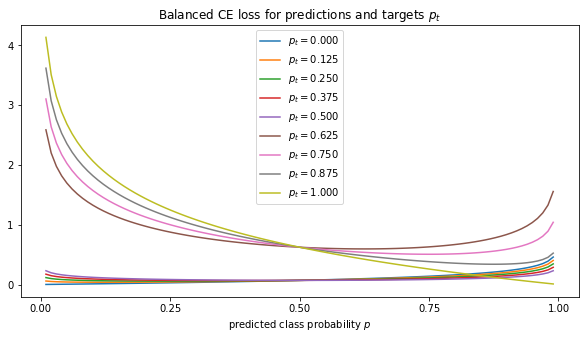

In [36]:
pred = torch.linspace(0, 1, 100).unsqueeze(1)
target = torch.linspace(0, 1, 9).unsqueeze(0)

class_freq = 0.1
class_thresh = 0.5
target_class = target > class_thresh

weight = torch.zeros_like(target)
weight[target_class] = 1 - class_freq
weight[~target_class] = class_freq


ce = weight * (-(1-target)*torch.log(1-pred) -target*torch.log(pred))

plt.plot(pred, ce, label=[f'$p_t={t.item():.3f}$' for t in target.T])
plt.xticks(torch.linspace(0, 1, 5))
plt.legend()
plt.xlabel('predicted class probability $p$')
plt.title('Balanced CE loss for predictions and targets $p_t$')

#### Focal Loss

Text(0.5, 1.0, 'CE-term for predictions, target $p_t=1$ and parameters $\\gamma$')

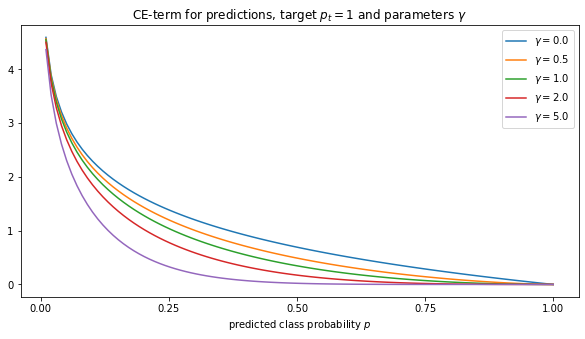

In [46]:
pred = torch.linspace(0, 1, 100).unsqueeze(1)
gamma = torch.tensor([0, 0.5, 1, 2, 5]).unsqueeze(0)


ce = - ((1-pred)**gamma) * torch.log(pred)
plt.plot(pred, ce, label=[f'$\gamma={g.item():.1f}$' for g in gamma.T])
plt.xticks(torch.linspace(0, 1, 5))
plt.legend()
plt.xlabel('predicted class probability $p$')
plt.title('CE-term for predictions, target $p_t=1$ and parameters $\gamma$')

Text(0.5, 1.0, 'CE loss for predictions, targets $p_t$ and $\\gamma=2$')

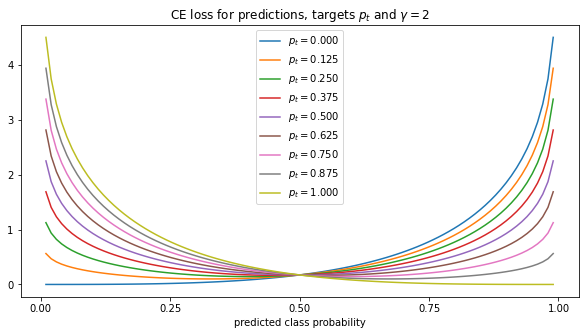

In [47]:
pred = torch.linspace(0, 1, 100).unsqueeze(1)
target = torch.linspace(0, 1, 9).unsqueeze(0)

gamma = 2
ce = - ((pred)**gamma) * (1-target)*torch.log(1-pred) -  ((1-pred)**gamma) * target*torch.log(pred)


plt.plot(pred, ce, label=[f'$p_t={t.item():.3f}$' for t in target.T])
plt.xticks(torch.linspace(0, 1, 5))
plt.legend()
plt.xlabel('predicted class probability')
plt.title(f'CE loss for predictions, targets $p_t$ and $\gamma={gamma}$')

Text(0.5, 1.0, 'BalancedCE loss for predictions, targets $p_t$ and $\\gamma=1$')

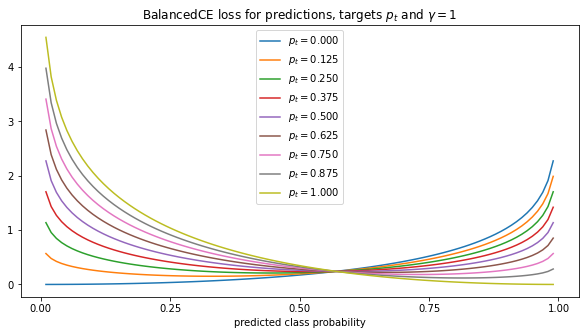

In [6]:
pred = torch.linspace(0, 1, 100).unsqueeze(1)
target = torch.linspace(0, 1, 9).unsqueeze(0)

gamma = 1
class_freq = 0.5
class_thresh = 0.5
target_class = target > class_thresh

weight = torch.zeros_like(target)
weight[target_class] = 1 - class_freq
weight[~target_class] = class_freq

ce = weight * - ((pred)**gamma) * (1-target)*torch.log(1-pred) -  ((1-pred)**gamma) * target*torch.log(pred)


plt.plot(pred, ce, label=[f'$p_t={t.item():.3f}$' for t in target.T])
plt.xticks(torch.linspace(0, 1, 5))
plt.legend()
plt.xlabel('predicted class probability')
plt.title(f'BalancedCE loss for predictions, targets $p_t$ and $\gamma={gamma}$')

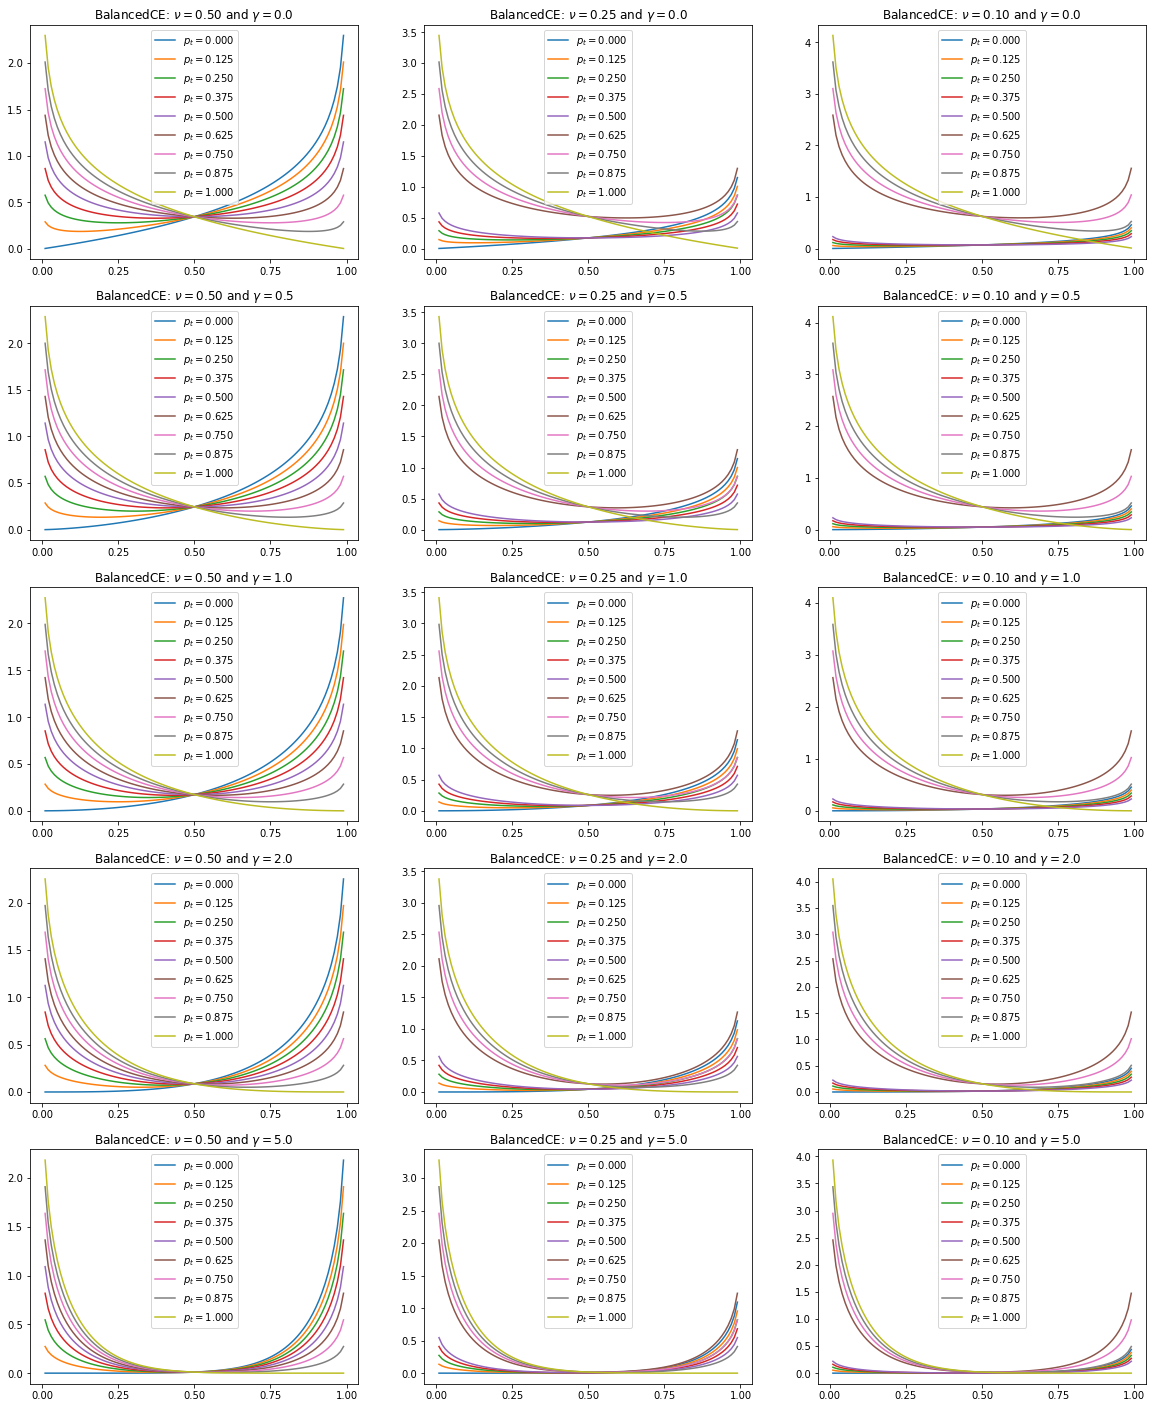

In [33]:

pred = torch.linspace(0, 1, 100).unsqueeze(1)
target = torch.linspace(0, 1, 9).unsqueeze(0)

class_thresh = 0.5
gammas = torch.tensor([0, 0.5, 1, 2, 5])
class_freqs = torch.tensor([0.5, 0.25, 0.1])

_, ax = plt.subplots(len(gammas), len(class_freqs), figsize=(20, 25))
for i, gamma in enumerate(gammas):
    for j, class_freq in enumerate(class_freqs):
        target_class = target > class_thresh

        weight = torch.ones_like(target)
        weight[target_class] = 1 - class_freq
        weight[~target_class] = class_freq

        ce = weight * (- ((pred)**gamma) * (1-target)*torch.log(1-pred) -  ((1-pred)**gamma) * target*torch.log(pred))
        
        ax[i][j].plot(pred, ce, label=[f'$p_t={t.item():.3f}$' for t in target.T])
        ax[i][j].set_xticks(torch.linspace(0, 1, 5))
        ax[i][j].set_title(f'BalancedCE: $\\nu={class_freq:.2f}$ and $\gamma={gamma}$')
        ax[i][j].legend()